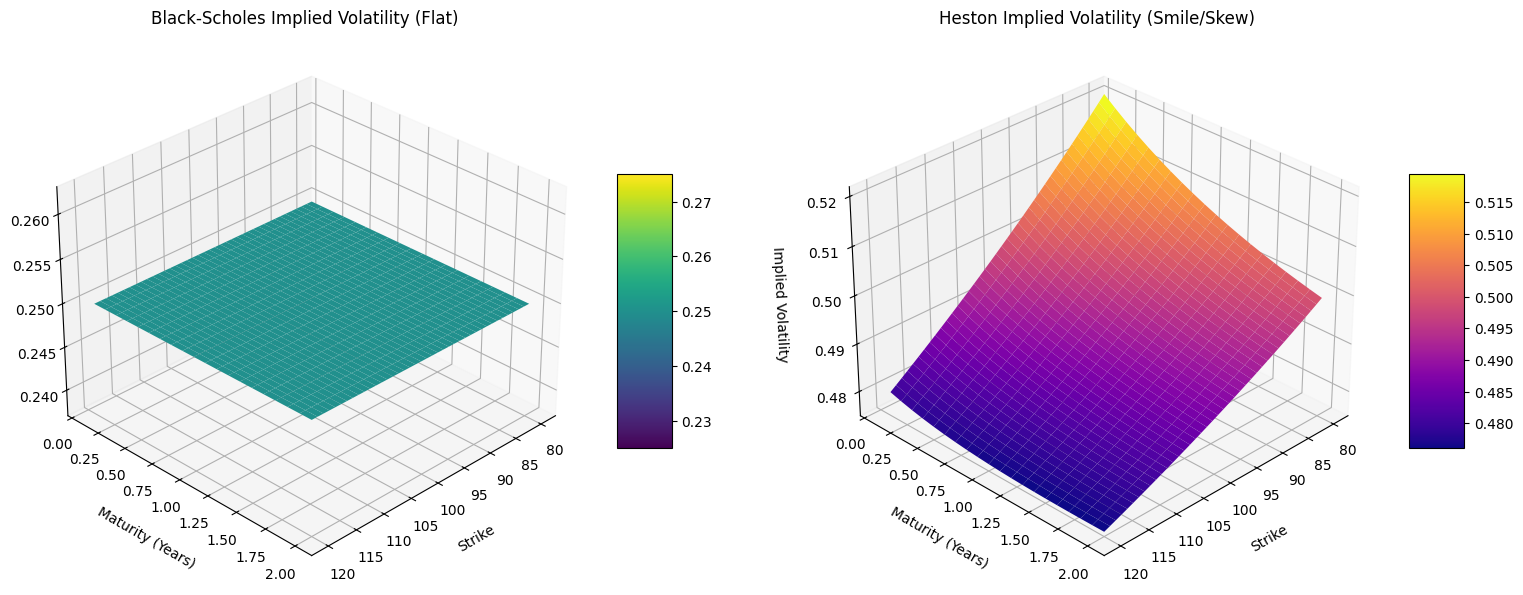

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.stats import norm
import QuantLib as ql

# Black-Scholes Model
def setup_black_scholes():
    strikes = np.linspace(80, 120, 40)
    maturities = np.linspace(0.1, 2.0, 20)
    K, T = np.meshgrid(strikes, maturities)
    bs_iv = np.full_like(K, 0.25)  # Constant 25% volatility
    return K, T, bs_iv


# 2. Heston Model using Fourier Transform for better accuracy
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_vol(C, S, K, T, r):
    if C < max(0.0, S - K * np.exp(-r*T)) + 1e-5:
        return np.nan
    try:
        return brentq(lambda sigma: bs_call(S, K, T, r, sigma) - C, 1e-6, 5.0)
    except:
        return np.nan

def heston_cf(phi, S, K, T, r, v0, kappa, theta, sigma, rho, Pnum):
    x = np.log(S)
    if Pnum == 1:
        u, b = 0.5, kappa - rho * sigma
    else:
        u, b = -0.5, kappa

    a = kappa * theta
    d = np.sqrt((rho * sigma * phi * 1j - b)**2 - sigma**2 * (2*u*phi*1j - phi**2))
    g = (b - rho*sigma*phi*1j + d) / (b - rho*sigma*phi*1j - d)

    C = r * phi * 1j * T + a / sigma**2 * ((b - rho*sigma*phi*1j + d)*T - 2*np.log((1 - g*np.exp(d*T))/(1 - g)))
    D = (b - rho*sigma*phi*1j + d) / sigma**2 * ((1 - np.exp(d*T)) / (1 - g*np.exp(d*T)))
    return np.exp(C + D * v0 + 1j * phi * x)

def heston_price(S, K, T, r, v0, kappa, theta, sigma, rho):
    integrand = lambda phi: np.real(np.exp(-1j*phi*np.log(K)) * heston_cf(phi, S, K, T, r, v0, kappa, theta, sigma, rho, 1) / (1j*phi))
    P1 = 0.5 + (1/np.pi) * quad(integrand, 0, 100)[0]
    integrand = lambda phi: np.real(np.exp(-1j*phi*np.log(K)) * heston_cf(phi, S, K, T, r, v0, kappa, theta, sigma, rho, 2) / (1j*phi))
    P2 = 0.5 + (1/np.pi) * quad(integrand, 0, 100)[0]
    return S * P1 - K * np.exp(-r*T) * P2

def setup_heston():
    # Parameters
    S0 = 100
    r = 0.05  # Matching QuantLib setup
    v0 = 0.25  # Initial variance
    kappa = 1.0  # Mean reversion speed
    theta = 0.25  # Long-term variance
    sigma_v = 0.3  # Vol of vol
    rho = -0.7  # Correlation

    strikes = np.linspace(80, 120, 40)
    maturities = np.linspace(0.1, 2.0, 20)
    K, T = np.meshgrid(strikes, maturities)

    iv_surface_heston = np.zeros((len(maturities), len(strikes)))

    for i, maturity in enumerate(maturities):
        for j, strike in enumerate(strikes):
            price = heston_price(S0, strike, maturity, r, v0, kappa, theta, sigma_v, rho)
            iv = implied_vol(price, S0, strike, maturity, r)
            iv_surface_heston[i, j] = iv if not np.isnan(iv) else np.nan

    from scipy import interpolate
    mask = np.isnan(iv_surface_heston)
    x = np.arange(0, iv_surface_heston.shape[1])
    y = np.arange(0, iv_surface_heston.shape[0])
    xx, yy = np.meshgrid(x, y)

    # Get only the valid values
    x1 = xx[~mask]
    y1 = yy[~mask]
    newarr = iv_surface_heston[~mask]

    iv_surface_heston = interpolate.griddata((x1, y1), newarr.ravel(),
                                          (xx, yy), method='cubic')

    return K, T, iv_surface_heston

# Generate and Plot Both Models
def plot_models():
    # Get data for both models
    K_bs, T_bs, bs_iv = setup_black_scholes()
    K_heston, T_heston, heston_iv = setup_heston()

    # Plotting
    fig = plt.figure(figsize=(16, 6))

    # Black-Scholes Surface
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(K_bs, T_bs, bs_iv, cmap='viridis', edgecolor='none')
    ax1.set_title('Black-Scholes Implied Volatility (Flat)', pad=10)
    ax1.set_xlabel('Strike', labelpad=10)
    ax1.set_ylabel('Maturity (Years)', labelpad=10)
    ax1.set_zlabel('Implied Volatility', labelpad=10)
    ax1.view_init(30, 45)
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    # Heston Surface
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(K_heston, T_heston, heston_iv, cmap='plasma', edgecolor='none')
    ax2.set_title('Heston Implied Volatility (Smile/Skew)', pad=10)
    ax2.set_xlabel('Strike', labelpad=10)
    ax2.set_ylabel('Maturity (Years)', labelpad=10)
    ax2.set_zlabel('Implied Volatility', labelpad=10)
    ax2.view_init(30, 45)
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

plot_models()